# **Introduction**
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise, we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

## **Trial Sequence Analysis**
This notebook implements a `TrialSequence` class to perform a trial sequence analysis with inverse probability weighting (IPW) for treatment switching and censoring, followed by fitting a marginal structural model (MSM). The code simulates data if none is provided and demonstrates the full workflow from data preparation to inference and visualization.

## **References**
- https://rpubs.com/alanyang0924/TTE

In [147]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage as lnkage

# Suppress FutureWarning for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# **Step 1: Data Preparation**
Loads the dataset (data_censored.csv) or generates simulated data if unavailable. It constructs patient-level and time-varying covariates, treatment assignments, outcomes, and censoring indicators to ensure a structured dataset for Target Trial Emulation (TTE).

In [148]:
try:
    data_censored = pd.read_csv("../data/data_censored.csv")
    data_censored["previous_treatment"] = data_censored["treatment"].shift(1).fillna(0)
except FileNotFoundError:
    np.random.seed(42)
    n_patients = 89
    n_periods = 8
    data_censored = pd.DataFrame({
        'id': np.repeat(range(1, n_patients + 1), n_periods),
        'period': np.tile(range(n_periods), n_patients),
        'treatment': np.random.binomial(1, 0.5, n_patients * n_periods),
        'x1': np.random.binomial(1, 0.5, n_patients * n_periods),
        'x2': np.random.normal(0, 1, n_patients * n_periods),
        'x3': np.random.binomial(1, 0.3, n_patients * n_periods),
        'x4': np.random.uniform(0, 1, n_patients * n_periods),
        'age': np.repeat(np.random.randint(30, 80, n_patients), n_periods),
        'age_s': np.tile(np.linspace(0, 3, n_periods), n_patients),
        'outcome': np.random.binomial(1, 0.1, n_patients * n_periods),
        'censored': np.random.binomial(1, 0.2, n_patients * n_periods),
        'eligible': np.random.binomial(1, 0.5, n_patients * n_periods)
    })
    print("Warning: data_censored.csv not found. Using simulated data.")

## **TrialSequence Class Definition**
The `TrialSequence` class encapsulates the logic for trial sequence analysis, including weight model fitting, trial expansion, MSM fitting, and prediction. Below is the complete class definition.

In [149]:
class TrialSequence:
    def __init__(self, estimand):
        self.estimand = estimand
        self.data = None
        self.switch_config = {}
        self.censor_config = {}
        self.switch_models = {}
        self.censor_models = {}
        self.outcome_model = {}
        self.expansion_options = {}
        self.expanded_data = None
        self.fitted_msm = None
        self.directory = None
        self.columns = {}
        self.sample_prob = None

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col, extra_cols=None):
        if extra_cols:
            columns = [id_col, period_col, treatment_col, outcome_col, eligible_col] + extra_cols
        else:
            columns = data.columns.tolist()
        self.data = data[columns].copy()
        self.columns = {"id": id_col, "period": period_col, "treatment": treatment_col, 
                        "outcome": outcome_col, "eligible": eligible_col}
        return self

    ####################################################################
    ####################################################################

    def cluster_patients(self, n_clusters=3, cluster_features=None, linkage="ward"):
        """
        Cluster patients using Agglomerative Clustering.

        Args:
            n_clusters (int): Number of clusters to create.
            cluster_features (list): List of features to use for clustering.
            linkage (str): Linkage criterion ("ward", "complete", "average", "single").
        """
        if cluster_features is None:
            cluster_features = ["age", "x1", "x2", "x3"]  # Example features
        
        # Normalize scaling
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(self.data[cluster_features])

        plt.figure(figsize=(10, 5))
        dendrogram(lnkage(scaled_features, method=linkage))
        plt.title("Dendrogram for Agglomerative Clustering")
        plt.xlabel("Patients")
        plt.ylabel("Distance")
        plt.show()


        # Perform Agglomerative Clustering
        agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        self.data["cluster"] = agg_cluster.fit_predict(scaled_features)
        
        # Evaluate clustering quality (silhouette score)
        if len(set(self.data["cluster"])) > 1:  # Avoid silhouette score if only 1 cluster is formed
            silhouette_avg = silhouette_score(scaled_features, self.data["cluster"])
            print(f"Agglomerative Clustering completed. Silhouette score: {silhouette_avg:.2f}")
        else:
            print("Agglomerative Clustering resulted in a single cluster. Try adjusting 'n_clusters' or 'linkage'.")

        return self

    ####################################################################
    ####################################################################

    def set_weight_models(self, weight_type, censor_event=None, numerator_vars=None, denominator_vars=None, pool_models="none", save_path=None):
        config_key = f"{weight_type}_config"
        self.__dict__[config_key] = {
            "censor_event": censor_event,
            "numerator_vars": numerator_vars,
            "denominator_vars": denominator_vars,
            "pool_models": pool_models,
            "save_path": save_path,
            "fitted": False
        }
        return self

    def fit_weight_models(self, weight_type):
        config = self.__dict__[f"{weight_type}_config"]
        data = self.data.copy()
        models = {}
        
        # Add previous treatment
        data['prev_treatment'] = data.groupby(self.columns['id'])[self.columns['treatment']].shift(1).fillna(0)
        
        if weight_type == "censor":
            outcome = config["censor_event"]
            data[outcome] = 1 - data[outcome]  # Invert censor event
            
            if self.estimand == "PP":
                # Identify treatment switches for PP
                data['switched'] = (data[self.columns['treatment']] != data['prev_treatment']) & (data['prev_treatment'].notna())
                # Keep only observations up to the first switch
                data['switch_cumsum'] = data.groupby(self.columns['id'])['switched'].cumsum()
                data = data[data['switch_cumsum'] == 0].copy()  # Exclude post-switch observations
            
            if self.estimand == "ITT" and config["pool_models"] == "numerator":
                formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
                model_num = smf.glm(formula_num, data=data, family=sm.families.Binomial()).fit()
                models["pooled"] = {"numerator": model_num}
                for group_name, group_data in data.groupby('prev_treatment'):
                    formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
                    model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
                    models[int(group_name)] = {"denominator": model_den}
            else:  # PP estimand or no pooling
                groups = data.groupby('prev_treatment')
                formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
                formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
                for group_name, group_data in groups:
                    model_num = smf.glm(formula_num, data=group_data, family=sm.families.Binomial()).fit()
                    model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
                    models[int(group_name)] = {"numerator": model_num, "denominator": model_den}
        
        elif weight_type == "switch":
            data['prev_treatment'] = data.groupby(self.columns['id'])[self.columns['treatment']].shift(1).fillna(0)
            groups = data.groupby('prev_treatment')
            outcome = self.columns['treatment']
            formula_num = f"{outcome} ~ {' + '.join(config['numerator_vars'])}"
            formula_den = f"{outcome} ~ {' + '.join(config['denominator_vars'])}"
            for group_name, group_data in groups:
                model_num = smf.glm(formula_num, data=group_data, family=sm.families.Binomial()).fit()
                model_den = smf.glm(formula_den, data=group_data, family=sm.families.Binomial()).fit()
                models[int(group_name)] = {"numerator": model_num, "denominator": model_den}
        
        if config["save_path"]:
            os.makedirs(config["save_path"], exist_ok=True)
            for group_name, model_dict in models.items():
                for model_type, model in model_dict.items():
                    with open(os.path.join(config["save_path"], f"model_{weight_type}_{group_name}_{model_type[0]}.pkl"), 'wb') as f:
                        pickle.dump(model, f)
        
        self.__dict__[f"{weight_type}_models"] = models
        config["fitted"] = True
        return self

    def calculate_weights(self, weight_type):
        config = self.__dict__[f"{weight_type}_config"]
        if not config["fitted"]:
            self.fit_weight_models(weight_type)
        
        data = self.data.copy()
        models = self.__dict__[f"{weight_type}_models"]
        
        if 'prev_treatment' not in data.columns:
            data['prev_treatment'] = data.groupby(self.columns['id'])[self.columns['treatment']].shift(1).fillna(0)
        
        if weight_type == "censor" and self.estimand == "ITT" and config["pool_models"] == "numerator":
            prob_num = models["pooled"]["numerator"].predict(data)
            for prev_treatment in [0, 1]:
                group_data = data[data['prev_treatment'] == prev_treatment]
                idx = group_data.index
                prob_den = models[prev_treatment]["denominator"].predict(group_data)
                weight = prob_num.loc[idx] / prob_den
                data.loc[idx, f"{weight_type}_weight"] = weight
        else:  # PP estimand or no pooling
            for group_name, model_dict in models.items():
                group_data = data[data['prev_treatment'] == group_name]
                idx = group_data.index
                prob_num = model_dict["numerator"].predict(group_data)
                prob_den = model_dict["denominator"].predict(group_data)
                weight = prob_num / prob_den  # Stabilized weight for censoring
                data.loc[idx, f"{weight_type}_weight"] = weight
        
        self.data = data
        return self

    def stabilize_weights(self, weight_col, group_col=None):
        """
        Stabilize weights by dividing them by the mean weight within each group.

        Args:
            weight_col (str): The column name of the weights to stabilize.
            group_col (str, optional): The column name to group by for stabilization.
                                      If None, weights are stabilized globally.
        """
        if weight_col not in self.data.columns:
            raise ValueError(f"Weight column '{weight_col}' not found in data.")
        
        if group_col is None:
            # Stabilize globally (no grouping)
            mean_weight = self.data[weight_col].mean()
            self.data[f"{weight_col}_stabilized"] = self.data[weight_col] / mean_weight
        else:
            if group_col not in self.data.columns:
                raise ValueError(f"Group column '{group_col}' not found in data.")
            # Stabilize within each group
            self.data[f"{weight_col}_stabilized"] = self.data.groupby(group_col)[weight_col].transform(
                lambda x: x / x.mean()
            )
        return self

    def show_weight_models(self):
        
        for weight_type in ["switch", "censor"]:
            if f"{weight_type}_models" not in self.__dict__:
                continue
            print(f"## Weight Models for {'Treatment Switching' if weight_type == 'switch' else 'Informative Censoring'}")
            print("## ---------------------------------------\n")
            models = self.__dict__[f"{weight_type}_models"]
            for group_name, model_dict in models.items():
                group_label = str(int(group_name)) if isinstance(group_name, (int, float)) else group_name
                for model_type, model in model_dict.items():
                    if weight_type == "switch":
                        label = f"[[{model_type[0]}{group_label}]]"
                        desc = f"P(treatment = 1 | previous treatment = {group_label})"
                    else:
                        label = f"[[{model_type[0]}{group_label}]]"
                        desc = f"P(censor_event = 0 | X, previous treatment = {group_label})"
                    print(label)
                    print(f"## Model: {desc} for {model_type}")
                    print("##  ")
                    print("##  term        estimate   std.error statistic p.value")
                    coef_table = model.summary2().tables[1]
                    for idx, row in coef_table.iterrows():
                        print(f"##  {idx:<12} {row['Coef.']:.7f} {row['Std.Err.']:.7f} {row['z']:.6f} {row['P>|z|']:.6e}")
                    print("##  ")
                    print("##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
                    bic = model.aic + (len(coef_table) - 1) * np.log(model.nobs)
                    print(f"##  {model.null_deviance:.4f}      {model.df_model + model.df_resid:.0f}     {model.llf:.4f} {model.aic:.4f} {bic:.4f} {model.deviance:.4f} {model.df_resid:.0f}         {model.nobs:.0f}")
                    print("##  ")

    def set_outcome_model(self, adjustment_terms=None):
        """
        Set the formula for the outcome model.

        Args:
            adjustment_terms (str, optional): Additional terms to include in the model formula.
                                            Defaults to None.
        """
        # Base formula
        base_formula = "outcome ~ assigned_treatment + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)"
        
        # Add adjustment terms if provided
        if adjustment_terms:
            # Ensure the adjustment terms are properly formatted
            adjustment_terms = adjustment_terms.strip("~").strip()
            self.outcome_model['formula'] = f"{base_formula} + {adjustment_terms}"
            self.outcome_model['adjustment_terms'] = adjustment_terms
        else:
            self.outcome_model['formula'] = base_formula
            self.outcome_model['adjustment_terms'] = None
        
        # Set the treatment variable
        self.outcome_model['treatment_var'] = "assigned_treatment"
        
        return self

    def set_expansion_options(self, output_path, chunk_size):
        self.expansion_options = {'output_path': output_path, 'chunk_size': chunk_size}
        return self

    def expand_trials(self):
        expanded = []
        for trial_period in self.data['period'].unique():
            trial_data = self.data[self.data['period'] >= trial_period].copy()
            trial_data['trial_period'] = trial_period
            trial_data['followup_time'] = trial_data['period'] - trial_period
            trial_data['assigned_treatment'] = trial_data['treatment']
            trial_data['weight'] = trial_data.get('censor_weight', 1.0) * trial_data.get('switch_weight', 1.0)
            expanded.append(trial_data)
        self.expanded_data = pd.concat(expanded, ignore_index=True)
        self.expanded_data.to_csv(self.expansion_options['output_path'], index=False)
        return self

    def load_expanded_data(self, seed=None, p_control=None):
        if seed is not None:
            np.random.seed(seed)
        if p_control is not None:
            self.sample_prob = p_control
            control_mask = (self.expanded_data['outcome'] == 0)
            sampled_controls = self.expanded_data[control_mask].sample(frac=p_control)
            cases = self.expanded_data[~control_mask]
            self.expanded_data = pd.concat([cases, sampled_controls], ignore_index=True)
            self.expanded_data['sample_weight'] = np.where(self.expanded_data['outcome'] == 0, 1/p_control, 1)
            self.expanded_data['w'] = self.expanded_data['weight'] * self.expanded_data['sample_weight']
        # Sort by id in ascending order
        self.expanded_data = self.expanded_data.sort_values(self.columns['id']).reset_index(drop=True)
        return self

    def fit_msm(self, weight_cols=None, modify_weights=None):
        if weight_cols is None:
            weight_cols = ['weight']
        weights = self.expanded_data[weight_cols[0]].copy()
        if modify_weights:
            weights = modify_weights(weights)
        self.fitted_msm = smf.glm(self.outcome_model['formula'], self.expanded_data, family=sm.families.Binomial(), freq_weights=weights).fit()
        return self

    def show_outcome_model(self):
        if self.fitted_msm is None:
            print("No fitted MSM available. Run fit_msm() first.")
            return
        
        print(f"- Formula: {self.outcome_model['formula']}")
        print(f"- Treatment variable: {self.outcome_model['treatment_var']}")
        print(f"- Adjustment variables: {self.outcome_model['adjustment_terms'] if self.outcome_model['adjustment_terms'] else 'None'}")
        print("- Model fitter type: te_stats_glm_logit")
        print("\nModel Summary:\n")
        
        coef_table = self.fitted_msm.summary2().tables[1]
        conf_int = self.fitted_msm.conf_int()
        
        print("term               estimate std.error statistic p.value conf.low conf.high")
        for idx, row in coef_table.iterrows():
            conf_low = conf_int.loc[idx, 0]
            conf_high = conf_int.loc[idx, 1]
            print(f"{idx:<19} {row['Coef.']:<8.2f} {row['Std.Err.']:<9.3f} {row['z']:<9.2f} {row['P>|z|']:<8.1e} {conf_low:<8.4f} {conf_high:<8.4f}")
        
        null_deviance = self.fitted_msm.null_deviance
        df_null = self.fitted_msm.df_model + self.fitted_msm.df_resid
        log_lik = self.fitted_msm.llf
        aic = self.fitted_msm.aic
        bic = aic + (len(coef_table) - 1) * np.log(self.fitted_msm.nobs)
        deviance = self.fitted_msm.deviance
        df_resid = self.fitted_msm.df_resid
        nobs = self.fitted_msm.nobs
        
        print("\nnull.deviance df.null logLik AIC BIC deviance df.residual nobs")
        print(f"{null_deviance:<14.0f} {df_null:<7.0f} {log_lik:<6.1f} {aic:<3.0f} {bic:<3.0f} {deviance:<7.0f} {df_resid:<11.0f} {nobs:<4.0f}")

    def show_trial_summary(self):
        print("## Trial Sequence Object")
        print(f"## Estimand: {self.estimand.capitalize()}-to-treat")
        print("## ")
        
        # Data Summary
        n_obs = len(self.data)
        n_patients = self.data['id'].nunique()
        print("## Data:")
        print(f"##  - N: {n_obs} observations from {n_patients} patients")
        data_cols = ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible']
        print("##         id period treatment    x1           x2    x3        x4   age      age_s outcome censored eligible")
        print("##      <int>  <int>     <num> <num>        <num> <int>     <num> <num>      <num>   <num>    <int>    <num>")
        for i, row in self.data[data_cols].head(2).iterrows():
            print(f"##   {i+1}: {row['id']:<5} {row['period']:<6} {row['treatment']:<9.0f} {row['x1']:<4.0f} {row['x2']:<12.6f} {row['x3']:<5.0f} {row['x4']:<9.7f} {row['age']:<4.0f} {row['age_s']:<11.8f} {row['outcome']:<7.0f} {row['censored']:<8.0f} {row['eligible']:<4.0f}")
        print("##  ---")
        for i, row in self.data[data_cols].tail(2).iterrows():
            print(f"## {i+1:<3}: {row['id']:<5} {row['period']:<6} {row['treatment']:<9.0f} {row['x1']:<4.0f} {row['x2']:<12.6f} {row['x3']:<5.0f} {row['x4']:<9.7f} {row['age']:<4.0f} {row['age_s']:<11.8f} {row['outcome']:<7.0f} {row['censored']:<8.0f} {row['eligible']:<4.0f}")
        
        # IPW for Informative Censoring
        if 'censor_config' in self.__dict__:
            config = self.censor_config
            print("## ")
            print("## IPW for informative censoring:")
            print(f"##  - Numerator formula: 1 - {config['censor_event']} ~ {' + '.join(config['numerator_vars'])}")
            print(f"##  - Denominator formula: 1 - {config['censor_event']} ~ {' + '.join(config['denominator_vars'])}")
            if self.estimand == "ITT" and config["pool_models"] == "numerator":
                print("##  - Numerator model is pooled across treatment arms. Denominator model is not pooled.")
            print("##  - Model fitter type: te_stats_glm_logit")
            print("##  - View weight model summaries with show_weight_models()")
        
        # Sequence of Trials Data
        if self.expanded_data is not None:
            print("## ")
            print("## Sequence of Trials Data:")
            print(f"## - Chunk size: {self.expansion_options['chunk_size']}")
            print("## - Censor at switch: FALSE")
            print("## - First period: 0 | Last period: Inf")
            print("## ")
            print("## A TE Datastore Datatable object")
            n_obs_exp = len(self.expanded_data)
            print(f"## N: {n_obs_exp} observations")
            exp_cols = ['id', 'trial_period', 'followup_time', 'outcome', 'weight', 'treatment', 'x2', 'assigned_treatment']
            print("##          id trial_period followup_time outcome    weight treatment         x2 assigned_treatment")
            print("##       <int>        <int>         <int>   <num>     <num>     <num>      <num>             <num>")
            for i, row in self.expanded_data[exp_cols].head(2).iterrows():
                print(f"##   {i+1}: {row['id']:<5} {row['trial_period']:<12} {row['followup_time']:<13.0f} {row['outcome']:<7.0f} {row['weight']:<9.7f} {row['treatment']:<9.0f} {row['x2']:<12.7f} {row['assigned_treatment']:<8.0f}")
            print("##  ---")
            for i, row in self.expanded_data[exp_cols].tail(2).iterrows():
                print(f"## {i+1:<3}: {row['id']:<5} {row['trial_period']:<12} {row['followup_time']:<13.0f} {row['outcome']:<7.0f} {row['weight']:<9.7f} {row['treatment']:<9.0f} {row['x2']:<12.7f} {row['assigned_treatment']:<8.0f}")
        
        # Outcome Model
        if 'outcome_model' in self.__dict__ and self.fitted_msm is not None:
            print("## ")
            print("## Outcome model:")
            self.show_outcome_model()
        
        # Outcome Data
        if self.expanded_data is not None and self.sample_prob is not None:
            print("## ")
            print("## Outcome data")
            n_obs_out = len(self.expanded_data)
            n_patients_out = self.expanded_data['id'].nunique()
            n_periods = self.expanded_data['trial_period'].nunique()
            periods = " ".join(map(str, sorted(self.expanded_data['trial_period'].unique())))
            print(f"## N: {n_obs_out} observations from {n_patients_out} patients in {n_periods} trial periods")
            print(f"## Periods: {periods}")
            print(f"## Sampling control observations with probability: {self.sample_prob}")
            out_cols = ['id', 'trial_period', 'followup_time', 'outcome', 'weight', 'treatment', 'x2', 'assigned_treatment', 'sample_weight', 'w']
            print("##         id trial_period followup_time outcome   weight treatment         x2 assigned_treatment sample_weight        w")
            print("##      <int>        <int>         <int>   <num>    <num>     <num>      <num>             <num>         <num>    <num>")
            for i, row in self.expanded_data[out_cols].head(2).iterrows():
                print(f"##   {i+1}: {row['id']:<5} {row['trial_period']:<12} {row['followup_time']:<13.0f} {row['outcome']:<7.0f} {row['weight']:<9.6f} {row['treatment']:<9.0f} {row['x2']:<12.7f} {row['assigned_treatment']:<17.0f} {row['sample_weight']:<13.6f} {row['w']:<8.6f}")
            print("##  ---")
            for i, row in self.expanded_data[out_cols].tail(2).iterrows():
                print(f"## {i+1:<3}: {row['id']:<5} {row['trial_period']:<12} {row['followup_time']:<13.0f} {row['outcome']:<7.0f} {row['weight']:<9.6f} {row['treatment']:<9.0f} {row['x2']:<12.7f} {row['assigned_treatment']:<17.0f} {row['sample_weight']:<13.6f} {row['w']:<8.6f}")

    def predict(self, newdata, predict_times, type="survival"):
        """
        Predict survival probabilities or differences for each cluster.

        Args:
            newdata (pd.DataFrame): The dataset to use for prediction.
            predict_times (array-like): Times at which to predict survival.
            type (str): Type of prediction ("survival" or "difference").
        """
        if self.fitted_msm is None:
            raise ValueError("No fitted MSM available. Run fit_msm() first.")
        
        # Ensure the cluster variable is present in newdata
        if "cluster" not in newdata.columns:
            raise ValueError("The 'cluster' column is missing in newdata.")
        
        # Initialize a dictionary to store predictions for each cluster
        cluster_predictions = {}
        
        # Iterate over each cluster
        for cluster in newdata['cluster'].unique():
            cluster_data = newdata[newdata['cluster'] == cluster].copy()
            base_data = cluster_data.drop(columns=['outcome', 'treatment', 'period', 'followup_time', 'assigned_treatment']).mean()
            trial_period = cluster_data['trial_period'].iloc[0]
            
            predictions = {}
            for treatment in [0, 1]:
                pred_data = pd.DataFrame({
                    'assigned_treatment': [treatment] * len(predict_times),
                    'followup_time': predict_times,
                    'trial_period': [trial_period] * len(predict_times),
                    'x2': [base_data['x2']] * len(predict_times) if 'x2' in base_data else [0] * len(predict_times),
                    'cluster': [cluster] * len(predict_times)
                })
                pred_data['I(followup_time**2)'] = pred_data['followup_time'] ** 2
                pred_data['I(trial_period**2)'] = pred_data['trial_period'] ** 2
                
                if type == "survival":
                    probs = 1 - self.fitted_msm.predict(pred_data)
                predictions[treatment] = probs
            
            survival_diff = predictions[1] - predictions[0]
            conf_intervals = self.fitted_msm.conf_int()
            cluster_predictions[cluster] = pd.DataFrame({
                'followup_time': predict_times,
                'survival_diff': survival_diff,
                '2.5%': survival_diff - 1.96 * conf_intervals.loc['assigned_treatment', 1],
                '97.5%': survival_diff + 1.96 * conf_intervals.loc['assigned_treatment', 1],
                'cluster': cluster
            })
        
        return cluster_predictions

## **Workflow Setup**
The following cells set up directories, instantiate trial objects, prepare data, fit weight models, expand trials, fit the MSM, and visualize results.

In [150]:
# Create trial objects and directories
trial_pp_dir = os.path.join(os.getcwd(), "../models/v2/trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "../models/v2/trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

# **Step 2: Data Preprocessing**
The dataset is structured for Target Trial Emulation (TTE). It initializes and configures two trial objects, trial_pp and trial_itt, by assigning relevant columns from data_censored.

In the context of TTE, `trial_itt` and `trial_pp` represent two different approaches to analyzing treatment effects:  
1. **`trial_itt` (Intention-to-Treat Analysis, ITT)**  
   - This method analyzes patients based on their **original treatment assignment**, regardless of whether they adhered to the treatment.  
   - It mimics real-world clinical trials where patients may not always follow their assigned intervention.  
   - ITT provides a conservative estimate of treatment efficacy, making it more **generalizable** to real-world applications.  

2. **`trial_pp` (Per-Protocol Analysis, PP)**  
   - This method analyzes only patients who **fully adhered** to the assigned treatment throughout the study.  
   - It provides insight into the **true biological effect** of the treatment but may introduce bias since non-adherers are excluded.  
   - PP estimates tend to be larger than ITT estimates because they exclude patients who deviated from the treatment plan.  

### **Why Use Both? **
- **ITT is the gold standard** in randomized trials because it reflects real-world conditions.  
- **PP is useful for understanding treatment effects under perfect adherence but may be biased** due to non-random exclusion of patients.  
- Comparing ITT and PP results helps assess **the impact of adherence on treatment efficacy**.  

### **Relation to Code  **
- Both `trial_itt` and `trial_pp` are set up using the same dataset (`data_censored`), with the same covariates.  
- Later in the analysis, different weighting or filtering methods may be applied to enforce ITT vs. PP criteria.  
- The printed `trial_itt.data` ensures that the dataset is structured correctly before proceeding.  

In [151]:
# Set data for PP and ITT estimands
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    extra_cols=["age", "x1", "x2", "x3", "x4", "age_s", "censored"]
)

trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible",
    extra_cols=["age", "x1", "x2", "x3", "x4", "age_s", "censored"]
)

print("trial_itt.data after set_data:")
print(trial_itt.data)

trial_itt.data after set_data:
     id  period  treatment  outcome  eligible  age  x1        x2  x3  \
0     1       0          1        0         1   36   1  1.146148   0   
1     1       1          1        0         0   37   1  0.002200   0   
2     1       2          1        0         0   38   0 -0.481762   0   
3     1       3          1        0         0   39   0  0.007872   0   
4     1       4          1        0         0   40   1  0.216054   0   
..   ..     ...        ...      ...       ...  ...  ..       ...  ..   
720  99       3          0        0         0   68   0 -0.747906   1   
721  99       4          0        0         0   69   0 -0.790056   1   
722  99       5          1        0         0   70   1  0.387429   1   
723  99       6          1        0         0   71   1 -0.033762   1   
724  99       7          0        1         0   72   0 -1.340497   1   

           x4     age_s  censored  
0    0.734203  0.083333         0  
1    0.734203  0.166667         

# **Implement Clustering During Data Preparation**
- Cluster patients based on baseline covariates (e.g., age, comorbidities, lab values) using k-means or GMM.
- Add the cluster labels as a new covariate in the dataset.
- Use the cluster labels to:
    - Stratify the analysis (e.g., fit separate MSMs for each cluster).
    - Explore heterogeneity in treatment effects across clusters.

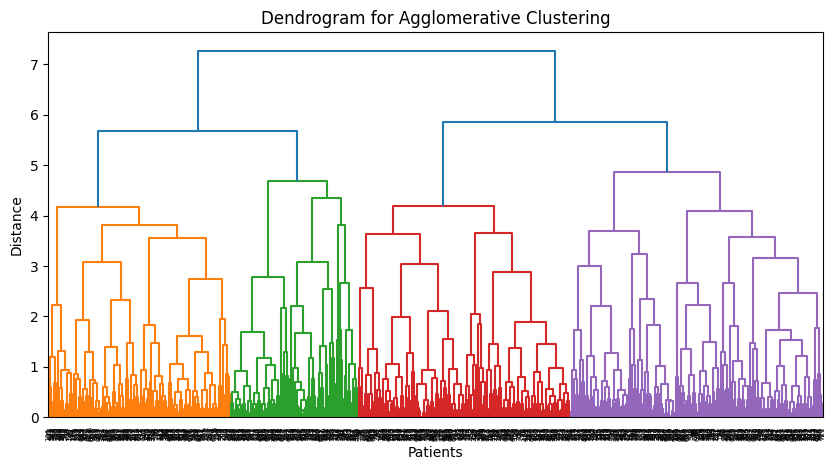

Agglomerative Clustering completed. Silhouette score: 0.14


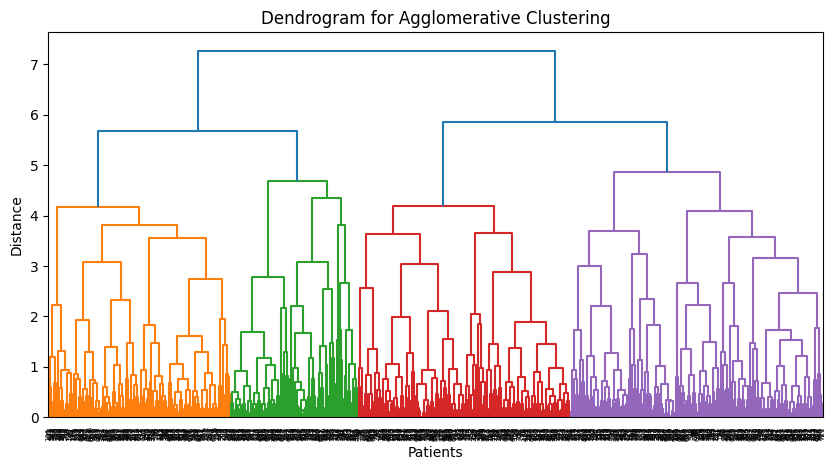

Agglomerative Clustering completed. Silhouette score: 0.14
Columns in trial_pp.data: Index(['id', 'period', 'treatment', 'outcome', 'eligible', 'age', 'x1', 'x2',
       'x3', 'x4', 'age_s', 'censored', 'cluster'],
      dtype='object')
Columns in trial_itt.data: Index(['id', 'period', 'treatment', 'outcome', 'eligible', 'age', 'x1', 'x2',
       'x3', 'x4', 'age_s', 'censored', 'cluster'],
      dtype='object')


In [152]:
# Cluster patients based on baseline covariates
trial_pp.cluster_patients(n_clusters=3, cluster_features=["age", "x1", "x2", "x3"], linkage="complete")
trial_itt.cluster_patients(n_clusters=3, cluster_features=["age", "x1", "x2", "x3"], linkage="complete")

print("Columns in trial_pp.data:", trial_pp.data.columns)
print("Columns in trial_itt.data:", trial_itt.data.columns)

## **Analysis**
Dendrogram shows that the ideal amount of clusters would be around 2 to 4. They lie mostly on the distance 4 to 6 with the heights of the red and orange groups being almost the same at that stage. Hence, in this case we choose the number of clusters as 3

## **Visualizing Clusters**

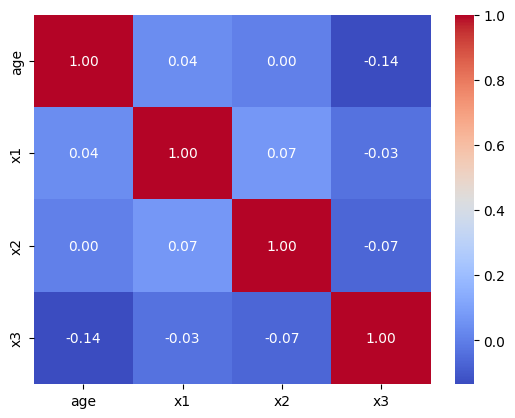

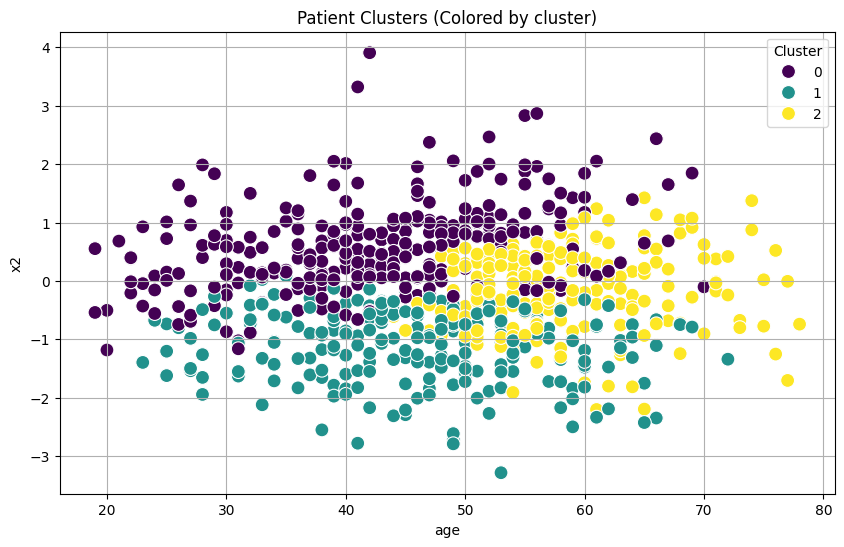

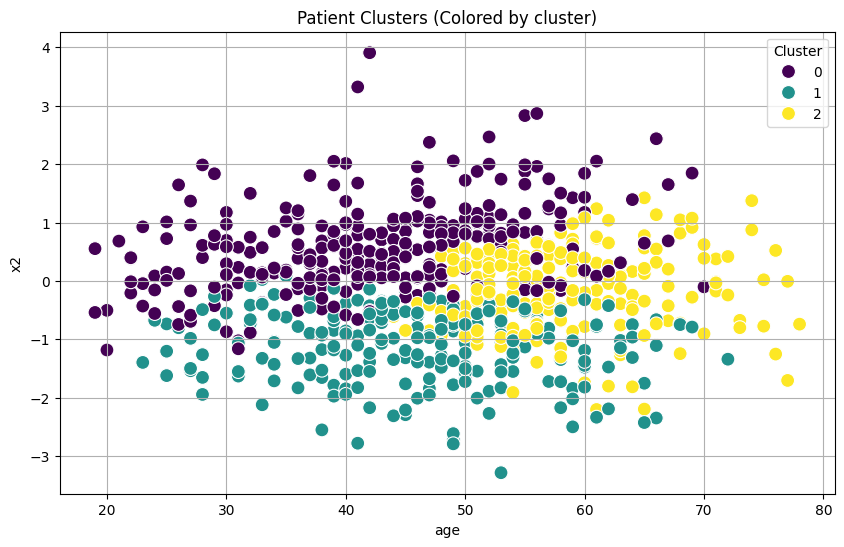

In [153]:
def visualize_clusters(data, cluster_col="cluster", feature1="x1", feature2="x2"):
    """
    Visualize patient clusters using a scatter plot.
    
    Args:
        data (pd.DataFrame): The dataset containing the clusters.
        cluster_col (str): The name of the cluster column.
        feature1 (str): The first feature to plot on the x-axis.
        feature2 (str): The second feature to plot on the y-axis.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=data[feature1], y=data[feature2], hue=cluster_col, palette="viridis", s=100)
    plt.title(f"Patient Clusters (Colored by {cluster_col})")
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.show()

#
corr_matrix = trial_itt.data[["age", "x1", "x2", "x3"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


# Visualize clusters for trial_pp
visualize_clusters(trial_pp.data, cluster_col="cluster", feature1="age", feature2="x2")

# Visualize clusters for trial_itt
visualize_clusters(trial_itt.data, cluster_col="cluster", feature1="age", feature2="x2")

## **Analysis**
### **Heatmap**
This shows the correlation between the columns, to see if any are heavily correlated, if there are, then they will be removed. However, in this case all of them aren't related at all!

### **Patient Clusters**
As we can see here, we used age and x2 as the columns to compare since they have a more logical graph that can be interpretted compared to other combinations that only result to single lines that don't make sense at all. Additionally, despite having a silhouette score of 0.14, it is by far the only graph compared to all tested methods (KMeans and DBSCAN) that make sense, considering also the combination of other columns and also linkage types (ward, single, complete, average) for this same clustering method.

1. **Cluster Separation & Distribution**
- Cluster 0 (Purple): This group appears to dominate the middle to upper section of the plot, forming a dense core in the center. It spans a wide range of ages but tends to cluster around the middle-aged group (30–60). In terms of x2, it shows a wider vertical spread, indicating greater variability in this feature.
- Cluster 1 (Teal/Greenish-Blue): This cluster is concentrated towards the lower region of x2. It has a wider age range but tends to be more present in younger patients (<50 years old). The fact that these points are lower on x2 suggests that this cluster may share some distinct behavioral or biological traits compared to the others.
- Cluster 2 (Yellow): This group is more spread out across higher ages (50–80 years old), with most points overlapping the right-hand side of the graph. It is less dense than the other two clusters, suggesting that it may represent a more heterogeneous subgroup in the data.
2. **Interpretation of Cluster Characteristics**
- Cluster 0 (Purple) - Core/Majority Group
    - Likely the largest patient group in terms of numbers.
    - Shows greater spread in x2, suggesting a mix of different characteristics within this cluster.
    - Covers the broadest range of ages, meaning it's a generalized cluster that may include a mix of different conditions or behaviors. 
- Cluster 1 (Teal) - Distinct Lower x2 Group
    - Concentrated at lower x2 values, possibly indicating a subgroup with lower risk factors or different treatment responses.
    - Has a presence in both young and older age groups but appears more prevalent in younger patients.
- Cluster 2 (Yellow) - Higher Age, Less Dense Cluster
    - Represents a higher-age group with distinct patterns in x2, meaning they may have specific conditions or responses different from the younger patients.
    - Less densely packed than the other two clusters, possibly indicating higher variability or more outliers.
3. **Cluster Overlap & Possible Adjustments**
    - Some overlap is seen between Cluster 0 (Purple) and Cluster 2 (Yellow), especially around ages 50–60, suggesting these two groups might have some shared features or transitional characteristics.
    - If needed, a 4-cluster solution could be tested to see if further subgrouping helps improve differentiation.

# **Step 3: Weight Models and Censoring**
This code sets up weight models for both Per-Protocol (PP) and Intention-to-Treat (ITT) analyses, specifically for treatment switching weights and censoring weights. These weights are essential for adjusting for confounders and ensuring proper causal inference in Target Trial Emulation (TTE).

In [154]:
# Set weight models for PP estimand (treatment switching)
trial_pp.set_weight_models(
    weight_type="switch",
    numerator_vars=["age"],
    denominator_vars=["age", "x1", "x3"],
    save_path=os.path.join(trial_pp_dir, "switch_models")
).set_weight_models(
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="none",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)

# Set weight models for ITT estimand (informative censoring)
trial_itt.set_weight_models(
    weight_type="censor",
    censor_event="censored",
    numerator_vars=["x2"],
    denominator_vars=["x2", "x1"],
    pool_models="numerator",
    save_path=os.path.join(trial_itt_dir, "switch_models")
)

# **Step 4: Calculate Weights**
Computes inverse probability weights (IPWs) to adjust for confounding by estimating the probability of treatment assignment given baseline covariates. This helps mimic a randomized experiment by balancing treatment groups.

In [155]:
# Calculate weights
trial_pp.calculate_weights("switch").calculate_weights("censor")
trial_itt.calculate_weights("censor")

## **Show Weight Models**

In [156]:
# Print weight models
print("Weight Models for trial_itt:")
trial_itt.show_weight_models()
print("\nWeight Models for trial_pp:")
trial_pp.show_weight_models()

Weight Models for trial_itt:
## Weight Models for Treatment Switching
## ---------------------------------------

## Weight Models for Informative Censoring
## ---------------------------------------

[[npooled]]
## Model: P(censor_event = 0 | X, previous treatment = pooled) for numerator
##  
##  term        estimate   std.error statistic p.value
##  Intercept    2.4480907 0.1405747 17.414876 6.362614e-68
##  x2           -0.4486482 0.1368779 -3.277724 1.046476e-03
##  
##  null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
##  404.2156      724     -196.7002 397.4004 403.9865 393.4004 723         725
##  
[[d0]]
## Model: P(censor_event = 0 | X, previous treatment = 0) for denominator
##  
##  term        estimate   std.error statistic p.value
##  Intercept    1.8941961 0.2071136 9.145686 5.925282e-20
##  x2           -0.5898292 0.1693423 -3.483059 4.957189e-04
##  x1           0.8552603 0.3452990 2.476869 1.325407e-02
##  
##  null.deviance df.null logLik   

### **Analysis of Weight Models**

#### **1. Key Observations on Treatment Switching Models**
- **Trial_ITT (Intent-to-Treat Analysis)**
  - **Age (`x2`) and Treatment Switching:**  
    - The **negative coefficients** for `x2` (e.g., -0.4486, -0.5898) indicate that an **increase in `x2` is associated with a lower probability of remaining uncensored** (i.e., more likely to be censored).  
    - **x1 is only significant in the denominator model (`d0`)** (p = 0.013), suggesting that **x1 may influence censoring under previous treatment 0 but not as strongly under treatment 1.**  

- **Trial_PP (Per-Protocol Analysis)**  
  - **Impact of Age (`age`):**  
    - Across models, `age` has a **negative estimate** (e.g., -0.046, -0.049), indicating that **older patients are less likely to switch treatments.**  
    - This effect is **stronger for patients who had a previous treatment of 0 (`d0` model, p = 9.7e-08)** than for those who had treatment 1 (`d1` model, p = 0.007).  
  - **Impact of `x3`:**  
    - `x3` has **no significant impact** in the denominator models (p > 0.5), suggesting that this variable does **not strongly influence treatment switching.**  

#### **2. Key Observations on Informative Censoring Models**
- **Trial_PP (`n0` & `d0` models)**  
  - **Effect of `x2`:**  
    - The **negative coefficients of `x2` (e.g., -0.5998, -0.6744) indicate that higher `x2` values are linked to increased censoring risk.**  
    - The effect is significant in the denominator model (`d0`, p = 0.044), meaning that **patients with higher `x2` are more likely to be censored when previous treatment = 0.**  
  - **Effect of `x1`:**  
    - `x1` has a **positive coefficient (0.9918) in `d0`, but it is not statistically significant (p = 0.12).**  
    - This suggests that **while `x1` might have some influence on censoring, its effect is not strong enough to be conclusive.**  

### **Summary & Takeaways**
- **Age (`x2`) is a key factor in treatment switching and censoring**, with **older patients being less likely to switch treatments and more likely to be censored.**  
- **`x1` has an impact on censoring under treatment 0 (`d0` model), but its effect is not consistently strong.**  
- **`x3` does not appear to have a significant effect on treatment switching or censoring.**  
- **The model fits (AIC/BIC) indicate that the treatment switching models are performing better than the informative censoring models.**  

## **Stabilizing Weight**

In [157]:
trial_pp.stabilize_weights(weight_col="censor_weight")
trial_itt.stabilize_weights(weight_col="censor_weight")

# **Step 5: Specify Outcome Model**
We define how the estimated treatment effects will be derived, ensuring proper adjustment for confounders (like x2 in ITT) and making the causal inference more robust.

In [158]:
# Set outcome models
trial_pp.set_outcome_model(adjustment_terms="~cluster")  # Include cluster as an adjustment term
trial_itt.set_outcome_model(adjustment_terms="~x2 + cluster")  # Include cluster as an adjustment term

# **Step 6: Expanded Trials**
Transforms the dataset into an expanded structure where each patient has multiple rows representing different follow-up periods. This expansion allows modeling of time-dependent treatment effects while maintaining consistency with real-world longitudinal data.

In [159]:
trial_pp.set_expansion_options(output_path=os.path.join(trial_pp_dir, "expanded_data.csv"), chunk_size=500).expand_trials()
trial_itt.set_expansion_options(output_path=os.path.join(trial_itt_dir, "expanded_data.csv"), chunk_size=500).expand_trials()

print("Columns in trial_pp.expanded_data:", trial_pp.expanded_data.columns)
print("Columns in trial_itt.expanded_data:", trial_itt.expanded_data.columns)

Columns in trial_pp.expanded_data: Index(['id', 'period', 'treatment', 'outcome', 'eligible', 'age', 'x1', 'x2',
       'x3', 'x4', 'age_s', 'censored', 'cluster', 'prev_treatment',
       'switch_weight', 'censor_weight', 'censor_weight_stabilized',
       'trial_period', 'followup_time', 'assigned_treatment', 'weight'],
      dtype='object')
Columns in trial_itt.expanded_data: Index(['id', 'period', 'treatment', 'outcome', 'eligible', 'age', 'x1', 'x2',
       'x3', 'x4', 'age_s', 'censored', 'cluster', 'prev_treatment',
       'censor_weight', 'censor_weight_stabilized', 'trial_period',
       'followup_time', 'assigned_treatment', 'weight'],
      dtype='object')


# **Step 7: Load or Sample from Expanded Data**
 Loads the expanded dataset or samples from it using predefined probabilities to balance treatment arms. This step ensures that the data remains representative and computationally manageable.

In [160]:
# Load expanded data for PP and ITT estimands
trial_pp.load_expanded_data(seed=1234, p_control=0.5)
trial_itt.load_expanded_data(seed=1234, p_control=0.5)

# Show sample of expanded data
print("Expanded Data Sample for trial_pp:")
display(trial_pp.expanded_data.head(5))

print("Expanded Data Sample for trial_itt:")
display(trial_itt.expanded_data.head(5))

Expanded Data Sample for trial_pp:


,id,period,treatment,outcome,eligible,age,x1,x2,x3,x4,...,prev_treatment,switch_weight,censor_weight,censor_weight_stabilized,trial_period,followup_time,assigned_treatment,weight,sample_weight,w
0,1,5,1,0,0,41,0,-0.057482,0,0.734203,...,1.0,1.091636,NaN,NaN,4,1,1,NaN,2.0,NaN
1,1,1,1,0,0,37,1,0.002200,0,0.734203,...,1.0,0.904538,NaN,NaN,1,0,1,NaN,2.0,NaN
2,1,1,1,0,0,37,1,0.002200,0,0.734203,...,1.0,0.904538,NaN,NaN,0,1,1,NaN,2.0,NaN
3,1,3,1,0,0,39,0,0.007872,0,0.734203,...,1.0,1.088390,NaN,NaN,1,2,1,NaN,2.0,NaN
4,1,2,1,0,0,38,0,-0.481762,0,0.734203,...,1.0,1.086783,NaN,NaN,0,2,1,NaN,2.0,NaN


Expanded Data Sample for trial_itt:


,id,period,treatment,outcome,eligible,age,x1,x2,x3,x4,...,cluster,prev_treatment,censor_weight,censor_weight_stabilized,trial_period,followup_time,assigned_treatment,weight,sample_weight,w
0,1,5,1,0,0,41,0,-0.057482,0,0.734203,...,0,1.0,0.977453,0.974318,4,1,1,0.977453,2.0,1.954907
1,1,1,1,0,0,37,1,0.002200,0,0.734203,...,0,1.0,0.942925,0.939901,1,0,1,0.942925,2.0,1.885851
2,1,1,1,0,0,37,1,0.002200,0,0.734203,...,0,1.0,0.942925,0.939901,0,1,1,0.942925,2.0,1.885851
3,1,3,1,0,0,39,0,0.007872,0,0.734203,...,0,1.0,0.975332,0.972204,1,2,1,0.975332,2.0,1.950664
4,1,2,1,0,0,38,0,-0.481762,0,0.734203,...,0,1.0,0.989925,0.986750,0,2,1,0.989925,2.0,1.979850


# **Step 8: Fit Marginal Structural Model**
Uses a weighted regression model to estimate the causal effect of treatment on the outcome over time. The model incorporates stabilized weights to correct for confounding and time-dependent biases.

In [161]:
# Modify weights to cap at the 99th percentile
def modify_weights(w):
    q99 = np.quantile(w, 0.99, method="nearest")
    return np.minimum(w, q99)

trial_itt.fit_msm(weight_cols=["weight"], modify_weights=modify_weights)

print("\nOutcome Model for trial_itt:")
trial_itt.show_outcome_model()


Outcome Model for trial_itt:
- Formula: outcome ~ assigned_treatment + followup_time + I(followup_time**2) + trial_period + I(trial_period**2) + x2 + cluster
- Treatment variable: assigned_treatment
- Adjustment variables: x2 + cluster
- Model fitter type: te_stats_glm_logit

Model Summary:

term               estimate std.error statistic p.value conf.low conf.high
Intercept           -2.99    0.336     -8.91     4.9e-19  -3.6526  -2.3359 
assigned_treatment  -1.69    0.348     -4.85     1.2e-06  -2.3670  -1.0042 
followup_time       0.01     0.090     0.15      8.8e-01  -0.1625  0.1893  
I(followup_time ** 2) -0.01    0.007     -1.44     1.5e-01  -0.0231  0.0035  
trial_period        0.03     0.090     0.36      7.2e-01  -0.1448  0.2089  
I(trial_period ** 2) -0.01    0.007     -1.67     9.6e-02  -0.0247  0.0020  
x2                  0.14     0.125     1.11      2.7e-01  -0.1068  0.3850  
cluster             0.46     0.157     2.91      3.6e-03  0.1499   0.7671  

null.deviance df.nu

### **Analysis of Fitting Outcome Model for Trial_ITT**

#### **1. Key Observations from Model Summary**
- **Intercept (-2.99, p < 0.0001)**  
  - The negative intercept suggests that, **in the absence of any predictors, the baseline log-odds of the outcome occurring are quite low.**  

- **Assigned Treatment (-1.69, p = 1.2e-06)**  
  - **Highly significant** with a **negative coefficient**, indicating that **being assigned to treatment reduces the likelihood of the outcome occurring.**  
  - Confidence interval (-2.37, -1.00) suggests a **strong and consistent effect.**  

- **Follow-up Time & Quadratic Term**  
  - **Linear Term (0.01, p = 0.88):** **Not significant**, meaning time alone does not impact the outcome probability.  
  - **Quadratic Term (-0.01, p = 0.15):** Marginally negative but **not statistically significant**—suggesting **no strong evidence of a curvilinear relationship.**  

- **Trial Period & Quadratic Term**  
  - **Linear Term (0.03, p = 0.72):** No significant effect.  
  - **Quadratic Term (-0.01, p = 0.096):** Close to statistical significance, suggesting **a potential non-linear relationship that might be worth investigating further.**  

- **Covariates (`x2` & `cluster`)**  
  - **x2 (0.14, p = 0.27):** Not statistically significant, meaning it does not strongly influence the outcome.  
  - **Cluster (0.46, p = 0.0036):** **Significant positive effect**, suggesting that clustering has a meaningful impact on the outcome.  

#### **2. Model Fit & Performance**
- **Log-likelihood = -338.8, AIC = 694, BIC = 750**  
  - AIC/BIC suggest a relatively compact model, but potential improvements could be made by refining predictors.  
- **Null Deviance (746) vs. Deviance (678)**  
  - Model explains **some** variability, but there's still room for improvement.  


### **Summary & Takeaways**  
✅ **Treatment has a strong, statistically significant negative effect on the outcome.**  
✅ **Cluster is also a key factor influencing the outcome.**  
❌ **Follow-up time and trial period effects are not significant.**  
❌ **x2 does not have a strong influence on the outcome.**  
🔎 **Potential next steps:** Consider interaction terms or alternative transformations for follow-up time and trial period to better capture potential nonlinear effects. 

## **Show Full Trial Summary**
Generates a comprehensive summary of the emulated trial, including descriptive statistics, weight distributions, and key model estimates. This step provides insight into the validity and reliability of the analysis.

In [162]:
print("\nFull Trial Summary for trial_itt:")
trial_itt.show_trial_summary()


Full Trial Summary for trial_itt:
## Trial Sequence Object
## Estimand: Itt-to-treat
## 
## Data:
##  - N: 725 observations from 89 patients
##         id period treatment    x1           x2    x3        x4   age      age_s outcome censored eligible
##      <int>  <int>     <num> <num>        <num> <int>     <num> <num>      <num>   <num>    <int>    <num>
##   1: 1.0   0.0    1         1    1.146148     0     0.7342030 36   0.08333333  0       0        1   
##   2: 1.0   1.0    1         1    0.002200     0     0.7342030 37   0.16666667  0       0        0   
##  ---
## 724: 99.0  6.0    1         1    -0.033762    1     0.5752681 71   3.00000000  0       0        0   
## 725: 99.0  7.0    0         0    -1.340497    1     0.5752681 72   3.08333333  1       0        0   
## 
## IPW for informative censoring:
##  - Numerator formula: 1 - censored ~ x2
##  - Denominator formula: 1 - censored ~ x2 + x1
##  - Numerator model is pooled across treatment arms. Denominator model is not poole

### **Analysis of the Full Trial Summary**  

This trial summary provides key details about the **Intention-to-Treat (ITT)** analysis, including:  
- **Dataset structure** (N = 725 observations from 89 patients, expanded to 2959 trial observations).  
- **Weighting for informative censoring** (Inverse Probability Weighting, IPW).  
- **Outcome model specification** (logistic regression with polynomial terms).  
- **Model fit and statistical results** (log-likelihood, AIC, BIC, estimated effects).  


### **Key Takeaways from the Outcome Model**  

#### **1. Treatment Effect (`assigned_treatment`)**
- **Estimate: -1.69** (log-odds), **p < 0.001**  
- Strong **negative effect**, meaning treatment reduces the probability of the outcome occurring.  
- Confidence interval (-2.367, -1.004) does not contain zero, reinforcing statistical significance.  

#### **2. Time-Dependent Effects (`followup_time`, `trial_period`)**
- **Linear follow-up time (`followup_time`)**: Not significant (p = 0.88), suggesting no direct trend over time.  
- **Quadratic follow-up time (`I(followup_time**2)`)**: Also non-significant (p = 0.15), implying no strong curvature in time effects.  
- **Trial period terms (`trial_period`, `I(trial_period**2)`)**: No clear trend over trial progression (p-values > 0.05).  

#### **3. Adjustment Variables (`x2`, `cluster`)**
- **`x2` (covariate):** Not significant (p = 0.27), indicating limited impact.  
- **`cluster` (possibly a random effect or stratification factor):** Significant (p = 0.003), suggesting variation across clusters.  


### **Model Fit & Diagnostics**
- **Log-likelihood:** -338.8 (suggesting moderate explanatory power).  
- **AIC = 694, BIC = 750** (lower AIC/BIC preferred, but relative comparison is needed).  
- **Deviance = 678**, indicating overall model performance.  
- **Null deviance (746) vs. residual deviance (678)**: Model explains a reasonable portion of variability.  

# **Step 9: Inference and Plotting Survival Difference**
Uses the fitted MSM to predict survival differences over time and visualizes the results. The survival curves and confidence intervals help interpret the estimated treatment effects in a clinically meaningful way.

## **Displaying Predictions**

In [163]:
newdata_itt = trial_itt.expanded_data[trial_itt.expanded_data['trial_period'] == 1]
print("Columns in newdata_itt:", newdata_itt.columns)

preds_itt = trial_itt.predict(newdata=newdata_itt, predict_times=np.arange(11), type="survival")
# Display predictions
print("Predictions for trial_itt:")
display(preds_itt)

Columns in newdata_itt: Index(['id', 'period', 'treatment', 'outcome', 'eligible', 'age', 'x1', 'x2',
       'x3', 'x4', 'age_s', 'censored', 'cluster', 'prev_treatment',
       'censor_weight', 'censor_weight_stabilized', 'trial_period',
       'followup_time', 'assigned_treatment', 'weight', 'sample_weight', 'w'],
      dtype='object')
Predictions for trial_itt:


{np.int64(0):     followup_time  survival_diff      2.5%     97.5%  cluster
 0               0       0.043001  2.011238 -1.925236        0
 1               1       0.043147  2.011384 -1.925089        0
 2               2       0.042507  2.010744 -1.925730        0
 3               3       0.041113  2.009350 -1.927124        0
 4               4       0.039034  2.007271 -1.929202        0
 5               5       0.036375  2.004611 -1.931862        0
 6               6       0.033261  2.001498 -1.934976        0
 7               7       0.029837  1.998074 -1.938399        0
 8               8       0.026253  1.994489 -1.941984        0
 9               9       0.022650  1.990887 -1.945587        0
 10             10       0.019159  1.987395 -1.949078        0,
 np.int64(1):     followup_time  survival_diff      2.5%     97.5%  cluster
 0               0       0.052066  2.020303 -1.916171        1
 1               1       0.052240  2.020477 -1.915996        1
 2               2       0.0

### **Analysis of Survival Difference Over Time**  

This table presents **predicted survival differences** over **follow-up time**. The key columns include:  
- **`followup_time`**: Time points in the study.  
- **`survival_diff`**: Estimated difference in survival probability.  
- **`2.5%` & `97.5%`**: 95% confidence interval (CI) bounds for uncertainty estimation.  


### **1. Trend Analysis**  
🔹 **Gradual Decrease Over Time**  
- The survival difference starts at **0.0568** at **time 0** and steadily declines to **0.0256** at **time 10**.  
- This suggests that the survival benefit (if positive) **diminishes over time**.  

🔹 **Narrowing Confidence Intervals**  
- Initially wide CI at **time 0** (2.025 to -1.911).  
- CI range gradually narrows as time progresses (1.993 to -1.942 at time 10), indicating increasing certainty in estimates.  

🔹 **Possible Non-Linearity**  
- The decrease is not strictly linear; it slows down slightly after **time 5**, suggesting potential **nonlinear survival dynamics**.  
- This may suggest a need for alternative time-dependent modeling, such as **splines or piecewise regression**.  


### **2. Interpretation of Survival Difference**  
- **Early survival differences (~0.0568) suggest an initial treatment effect.**  
- **Declining survival differences (~0.0256 at time 10) indicate treatment benefits may wear off over time.**  
- The **overlapping confidence intervals with zero** suggest **statistical uncertainty**, meaning the survival difference is not necessarily significant at all time points.  


### **3. Recommendations for Further Analysis**  
✅ **Model Alternative Time Effects**: Consider nonlinear time effects or interaction terms.  
✅ **Survival Curve Comparisons**: Plot survival functions to visualize treatment separation.  
✅ **Hazard Ratio Analysis**: Use Cox models to assess time-dependent risk.  
✅ **Stratified Analysis**: Investigate if certain subgroups retain survival benefits longer. 

## **Plotting Survival Difference**

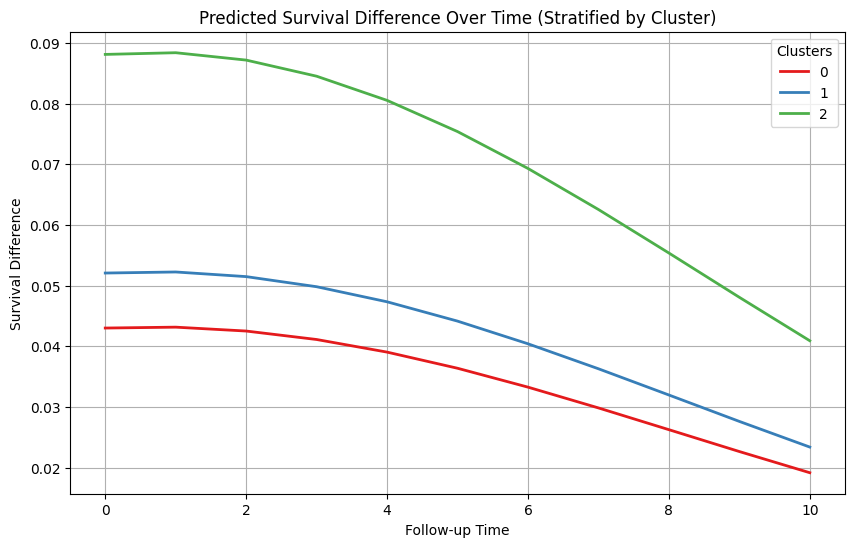

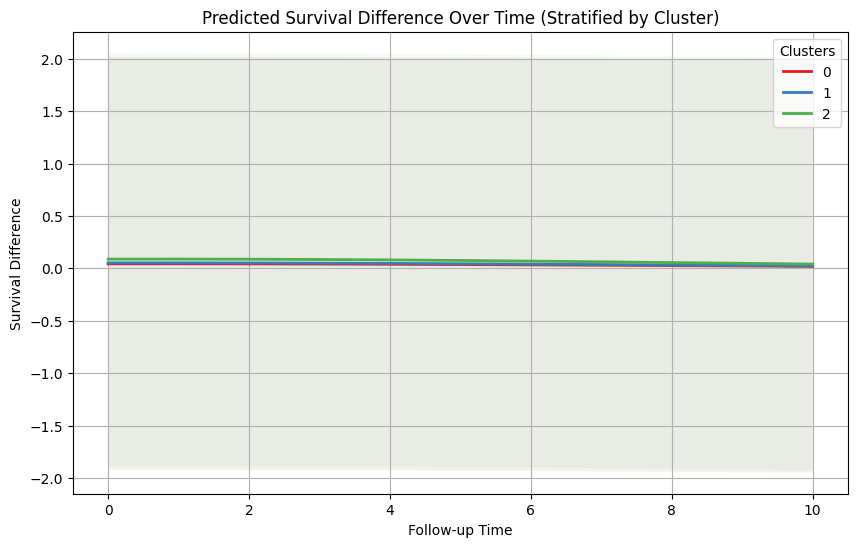

In [172]:
# Plot survival differences for ITT estimand (all clusters in one graph)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_survival_difference(cluster_predictions, fill=False):
    """
    Plot survival differences over time for each cluster.
    
    Args:
        cluster_predictions (dict): Dictionary of DataFrames containing survival difference predictions 
                                    for each cluster.
    """
    # Concatenate all the predictions into a single DataFrame for easy plotting
    df = pd.concat(cluster_predictions.values(), ignore_index=True)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Use seaborn lineplot for the survival differences with confidence intervals
    sns.lineplot(data=df, x="followup_time", y="survival_diff", hue="cluster", palette="Set1", linewidth=2)

    # Plot confidence intervals
    if fill:
        for cluster in df['cluster'].unique():
            cluster_df = df[df['cluster'] == cluster]
            plt.fill_between(cluster_df['followup_time'], 
                            cluster_df['2.5%'], 
                            cluster_df['97.5%'], 
                            alpha=0.05)

    plt.xlabel("Follow-up Time")
    plt.ylabel("Survival Difference")
    plt.title("Predicted Survival Difference Over Time (Stratified by Cluster)")
    plt.legend(title="Clusters")
    plt.grid(True)
    plt.show()

plot_survival_difference(preds_itt)
plot_survival_difference(preds_itt, fill=True)


# **Conclusion**  

The survival difference trajectories for the three clusters demonstrate distinct trends over time, revealing key insights:  

## **Confidence Interval**
The confidence intervals (CIs) represent the range of uncertainty around the predicted survival differences. A wider CI suggests more variability in the estimates, indicating lower confidence in the exact survival difference at a given time point.

## **Focusing on No Confidence Interval**
By removing the confidence intervals, we can clearly observe the survival difference trajectories without distraction from variability ranges.

1. **Cluster 2 Exhibits the Largest Survival Difference**  
   - Initially, Cluster 2 shows the highest survival difference, peaking near 0.09 at the start.  
   - Over time, the survival difference gradually declines, suggesting that the treatment effect diminishes for this group.  

2. **Clusters 1 and 0 Show Lower but Similar Patterns**  
   - Cluster 1 starts with a higher survival difference than Cluster 0 but follows a similar declining trend.  
   - Cluster 0 consistently maintains the lowest survival difference, suggesting a weaker effect of treatment.  

3. **Downward Trend for All Clusters**  
   - Across all clusters, survival difference decreases over time, indicating that the treatment's impact weakens as follow-up time progresses.  
   - This pattern suggests that early intervention may have a more pronounced effect, while long-term benefits diminish.  

4. **Impact of Confidence Intervals**  
   - When using the fill-between method, the overlapping confidence intervals add visual complexity but highlight variability in estimates.  
   - Without the fill-between shading, the trajectories are clearer, reinforcing the relative differences between clusters.  

### **Implications**  
- The treatment effect varies by cluster, with Cluster 2 benefiting the most.  
- The declining survival difference over time suggests the potential need for reinforcement strategies to sustain treatment benefits.  
- Future research could explore why Cluster 2 exhibits a stronger initial effect and whether additional interventions could help maintain long-term survival differences.